In [1]:
import os
os.environ['OMP_NUM_THREADS']="1"
from firedrake import *
import matplotlib.pyplot as plt
from firedrake import *
from firedrake.pyplot import triplot
import pyvista as pv
import math
import operator

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)

In [3]:
dim = 2
x,y = SpatialCoordinate(mesh)

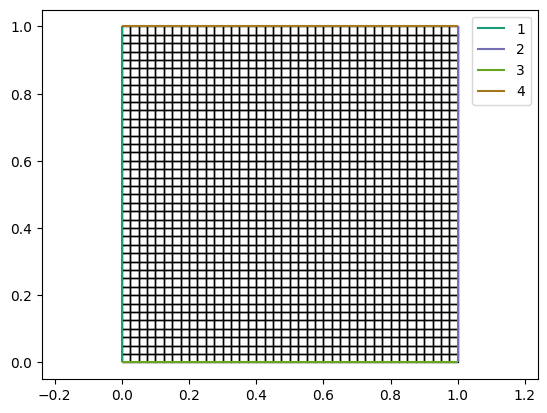

In [4]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh, axes=axes)
axes.legend()

In [5]:
label_top = 1
label_bottom = 2

x, y = SpatialCoordinate(mesh)
V = FunctionSpace(mesh, "DP", 0)
top_half_func = Function(V).interpolate(conditional(y > 0.5, 1., 0.))
bottom_half_func = Function(V).interpolate(conditional(y > 0.5, 0., 1.))
mesh2 = RelabeledMesh(mesh,[top_half_func,bottom_half_func],[label_top,label_bottom])

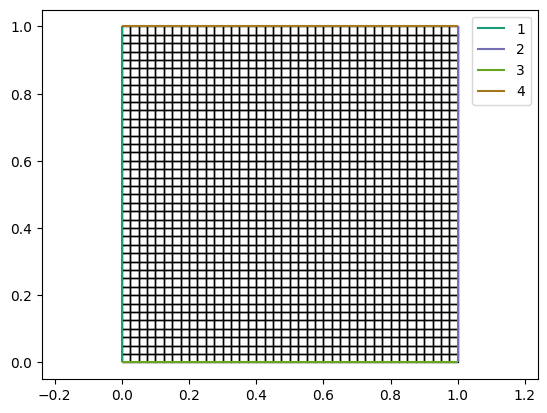

In [6]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh2, axes=axes)
axes.legend()

In [7]:
mesh_top = Submesh(mesh2, dim, label_top, name="mesh_v")
mesh_bottom = Submesh(mesh2, dim, label_bottom, name="mesh_c")

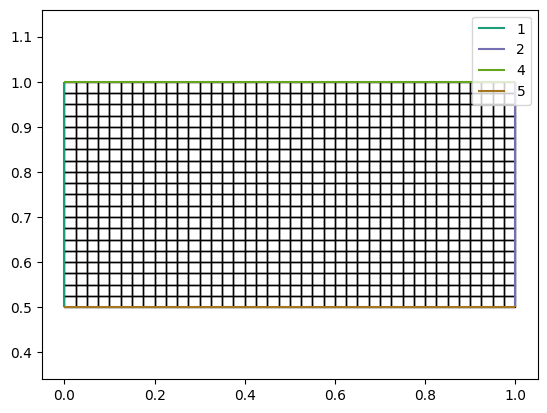

In [8]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh_top, axes=axes)
axes.legend()

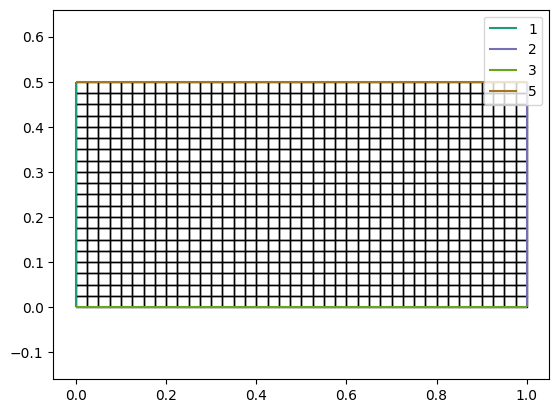

In [9]:
fig, axes = plt.subplots()
axes.axis('equal')
collection = triplot(mesh_bottom, axes=axes)
axes.legend()

## Base case starts here

In [10]:
V_top = VectorFunctionSpace(mesh_top, "CG", 2)  # Velocity function space (vector)
W_top = FunctionSpace(mesh_top, "CG", 1)  # Pressure function space (scalar)
Q_top = FunctionSpace(mesh_top, "CG", 2)  # Temperature function space (scalar)
Z_top = V_top * W_top

V_bottom = VectorFunctionSpace(mesh_bottom, "CG", 2)  # Velocity function space (vector)
W_bottom = FunctionSpace(mesh_bottom, "CG", 1)  # Pressure function space (scalar)
Q_bottom = FunctionSpace(mesh_bottom, "CG", 2)  # Temperature function space (scalar)
Z_bottom = V_bottom * W_bottom

V = V_top * V_bottom
W = W_top * W_bottom
Q = Q_top * Q_bottom
Z = V_top * V_bottom * W_top * W_bottom

In [11]:
z = Function(Z)
u_top, u_bottom, p_top, p_bottom = split(z)
for subf, name in zip(z.subfunctions, ["velocity_top", "pressure_top", "velocity_bottom", "pressure_bottom"]):
    subf.rename(name)

T = Function(Q)
T_top, T_bottom = T.subfunctions
X_top = SpatialCoordinate(mesh_top)
T_top.interpolate((1.0-X_top[1]) + (0.05*cos(pi*X_top[0])*sin(pi*X_top[1])))
X_bottom = SpatialCoordinate(mesh_bottom)
T_bottom.interpolate((1.0-X_bottom[1]) + (0.05*cos(pi*X_bottom[0])*sin(pi*X_bottom[1])))

z_test = TestFunction(Z)
u_test_top, u_test_bottom, p_test_top, p_test_bottom = split(z_test)
q_test_top, q_test_bottom = split(TestFunction(Q))

z_trial = TrialFunction(Z)
u_trial_top, u_trial_bottom, p_trial_top, p_trial_bottom = split(z_trial)
q_test_trial, q_test_trial = split(TestFunction(Q))

norm_top = FacetNormal(mesh_top)
norm_bottom = FacetNormal(mesh_bottom)
norm_all = FacetNormal(mesh2)

dx_top = Measure("dx", domain=mesh_top)
ds_top = Measure("ds", domain=mesh_top)
dS_top = Measure("dS", domain=mesh_top)

dx_bottom = Measure("dx", domain=mesh_bottom)
ds_bottom = Measure("ds", domain=mesh_bottom)
dS_bottom = Measure("dS", domain=mesh_bottom)

Ra = Constant(1e4)  # Rayleigh number

time = 0.0  # Initial time
delta_t = Constant(1e-3)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.

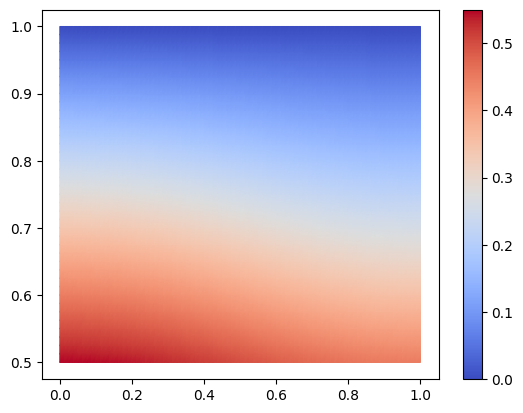

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T_top, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

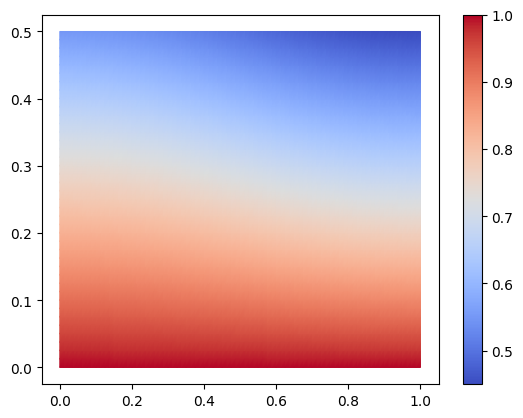

In [13]:
fig, axes = plt.subplots()
collection = tripcolor(T_bottom, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

In [14]:
stokes_subspaces = Z.subspaces
V_nullspace_top = stokes_subspaces[0]
V_nullspace_bottom = stokes_subspaces[1]
p_nullspace_top = VectorSpaceBasis(constant=True,comm=Z_top.mesh().comm)
p_nullspace_bottom = VectorSpaceBasis(constant=True,comm=Z_bottom.mesh().comm)
Z_nullspace = MixedVectorSpaceBasis(Z,[V_nullspace_top,V_nullspace_bottom,p_nullspace_top,p_nullspace_bottom])

## Energy Solver

In [15]:
direct_energy_solver_parameters= {
    "mat_type": "aij",
    "snes_type": "ksponly",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_monitor": None,
}

In [16]:
def F_advection(test, trial, u, n, dx, ds):
    return trial * div(test * u) * dx - trial * dot(n,u) * test * ds
    #return 0

def F_diffusion(test, trial, dx):
    return -( inner(grad(test),grad(trial)) * dx )

def F_mass( test, trial, dx ):
    return dot(test,trial) * dx

#def F_zero( test, dx ):
#    return test * Constant(0) * dx

In [17]:
a = np.array([[0.5]])
b = np.array([1.0])
c = np.array([0.5])
quad_degree = 5

energy_bcs_top = [ DirichletBC(Q.sub(0),0.0,4), DirichletBC(Q.sub(0),T_top,5) ]
energy_bcs_bottom = [ DirichletBC(Q.sub(1),1.0,3), DirichletBC(Q.sub(1),T_bottom,5) ]
hom_bcs = [bci.__class__(bci.function_space(), 0, bci.sub_domain) for bci in energy_bcs_top] + [ bci.__class__(bci.function_space(), 0, bci.sub_domain) for bci in energy_bcs_bottom]

T_old = Function(Q)
T_old_top, T_old_bottom = split(T_old)

tendency = Function(Q)
tendency_top, tendency_bottom = split(tendency)

u_inner_top = T_old_top + 0.5*delta_t*tendency_top
#F_energy_top = F_mass(q_test_top,tendency_top,dx_top) - ( F_advection(q_test_top,u_inner_top,u_top,norm_top,dx_top,ds_top) + F_diffusion(q_test_top,u_inner_top,dx_top))
F_energy_top = F_mass(q_test_top,tendency_top,dx_top)

u_inner_bottom = T_old_bottom + 0.5*delta_t*tendency_bottom
F_energy_bottom = F_mass(q_test_bottom,tendency_bottom,dx_bottom) - ( F_advection(q_test_bottom,u_inner_bottom,u_bottom,norm_bottom,dx_bottom,ds_bottom) + F_diffusion(q_test_bottom,u_inner_bottom,dx_bottom))


energy_problem = NonlinearVariationalProblem(F_energy_top + F_energy_bottom,tendency,bcs=hom_bcs)
energy_solver = NonlinearVariationalSolver(energy_problem, solver_parameters=direct_energy_solver_parameters)
sol_expr_top = tendency.sub(0) * 0.5*delta_t
sol_expr_bottom = tendency.sub(1) * 0.5 * delta_t
final_sol_expr_top = T_old.sub(0) + tendency.sub(0) * delta_t
final_sol_expr_bottom = T_old.sub(1) + tendency.sub(1) * delta_t

In [18]:
tendency.subfunctions

(Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe658cf0dd0>, FiniteElement('Q', quadrilateral, 2), name=None, index=0, component=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 8)), 42),
 Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe658cf39e0>, FiniteElement('Q', quadrilateral, 2), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 10)), 43))

## Stokes solver

In [19]:
stokes_solver_parameters = {"snes_type": "ksponly",
    "mat_type": "aij",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
#    "snes_monitor": None,
}

In [20]:
### Stokes Solver
stokes_bcs = [ 
    DirichletBC(Z.sub(0).sub(0), 0.0, 1), 
    DirichletBC(Z.sub(0).sub(0), 0.0, 2), 
    DirichletBC(Z.sub(0).sub(1), 0.0, 4),
    DirichletBC(Z.sub(1).sub(0), 0.0, 1), 
    DirichletBC(Z.sub(1).sub(0), 0.0, 2), 
    DirichletBC(Z.sub(1).sub(1), 0.0, 3),
    EquationBC(inner(u_top-u_bottom,u_test_bottom) * ds_bottom(5) == 0,z,5,V=Z.sub(1)),
    #EquationBC(inner(u_top-u_bottom,u_test_top) * ds_top(5) == 0,z,5,V=Z.sub(0)),
    #EquationBC(inner(p_top-p_bottom,p_test_top) * ds_bottom(5) == 0,z,5,V=Z.sub(2)), ### Pressure across middle boundary
]

stress_top = 2 * sym(grad(u_top))
stress_bottom = 2 * sym(grad(u_bottom))
source_top = ( Ra * T_top ) * as_vector([0,1])
source_bottom = ( Ra * T_bottom ) * as_vector([0,1])

def F_viscosity(test,stress,dx):
    return -( inner(nabla_grad(test),stress ) * dx )

def F_pressure_gradient(test, p, dx):
    return dot(div(test),p) * dx

def F_divergence(test, u, dx):
    return dot(test, div(u)) * dx

def F_momentum_source(test,source,dx):
    return dot(test,source) * dx

F_stokes_top = -F_momentum_source(u_test_top,source_top,dx_top) - F_pressure_gradient(u_test_top,p_top,dx_top) - F_viscosity(u_test_top,stress_top,dx_top) - F_divergence(p_test_top,u_top,dx_top)
F_stokes_bottom = -F_momentum_source(u_test_bottom,source_bottom,dx_bottom) - F_pressure_gradient(u_test_bottom,p_bottom,dx_bottom) - F_viscosity(u_test_bottom,stress_bottom,dx_bottom) - F_divergence(p_test_bottom,u_bottom,dx_bottom)

stokes_problem = NonlinearVariationalProblem(F_stokes_top + F_stokes_bottom,z,bcs=stokes_bcs)
stokes_solver = NonlinearVariationalSolver(stokes_problem,solver_parameters=stokes_solver_parameters,nullspace=Z_nullspace,transpose_nullspace=Z_nullspace)

In [21]:
for timestep in range(0,timesteps):

    stokes_solver.solve()

    for bci in energy_bcs_top:
        bci.apply(T)
    for bci in energy_bcs_bottom:
        bci.apply(T)
    for subfunction, subfunction_0 in zip(T.subfunctions, T_old.subfunctions):
        subfunction_0.assign(subfunction)

    energy_solver.solve()

    T.sub(0).assign(T_old.sub(0) + sol_expr_top)
    T.sub(1).assign(T_old.sub(1) + sol_expr_bottom)
    T.sub(0).assign(final_sol_expr_top)
    T.sub(1).assign(final_sol_expr_bottom)

    maxchange = sqrt(assemble((T.sub(0) - T_old.sub(0))**2 * dx_top) + assemble((T.sub(1) - T_old.sub(1))**2 * dx_bottom))
    if maxchange < steady_state_tolerance:
        print("Done?")
        break
    if timestep == 0:
        break
    

Done?


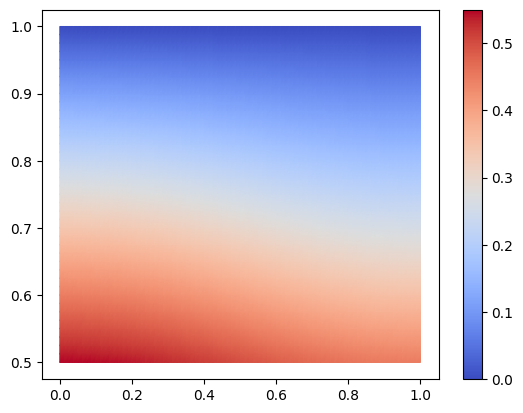

In [22]:
fig, axes = plt.subplots()
collection = tripcolor(T_top, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

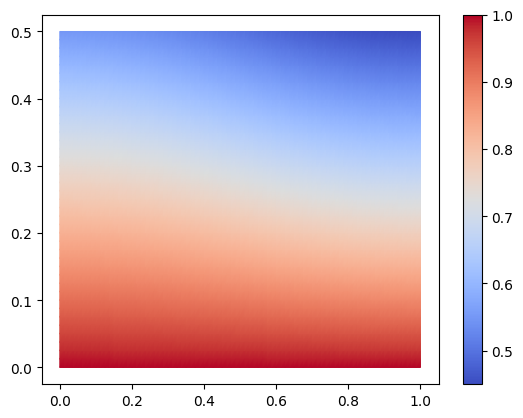

In [23]:
fig, axes = plt.subplots()
collection = tripcolor(T_bottom, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

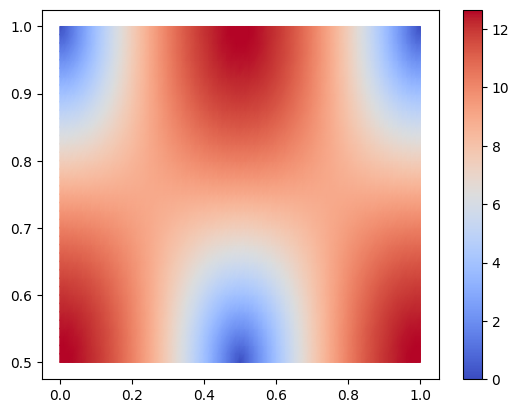

In [24]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(0), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

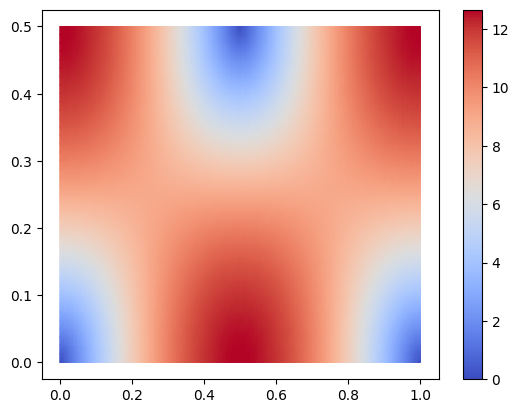

In [25]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(1), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

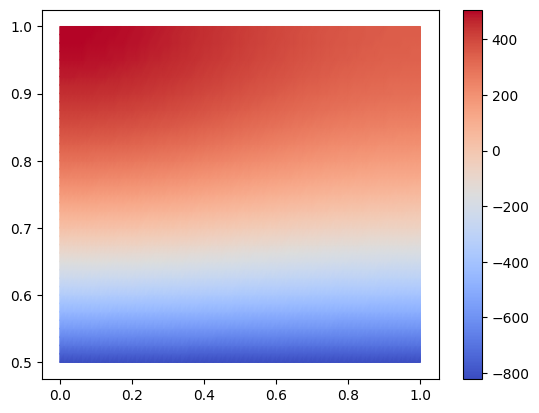

In [26]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(2), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

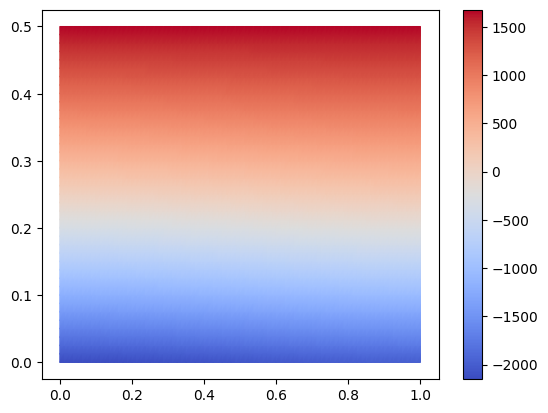

In [27]:
fig, axes = plt.subplots()
collection = tripcolor(z.sub(3), axes=axes, cmap='coolwarm')
fig.colorbar(collection);

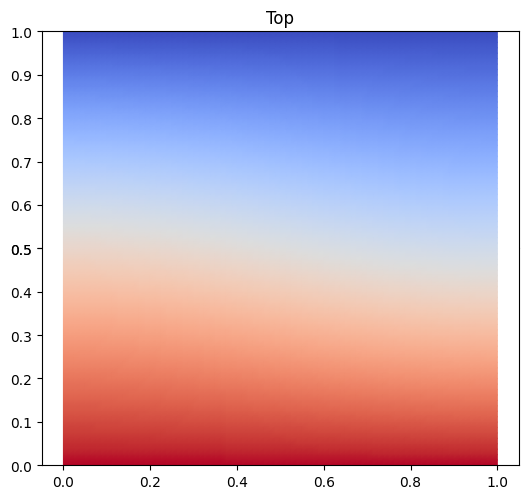

In [28]:
fig, axes = plt.subplots(nrows=2, sharex=True)

tripcolor(T_top, axes=axes[0],vmin=0,vmax=1, cmap='coolwarm')
axes[0].set_aspect("equal")
axes[0].set_title("Top")
axes[0].set_ylim(0.5,1.0)
axes[0].spines['bottom'].set_visible(False)

tripcolor(T_bottom, axes=axes[1],vmin=0,vmax=1, cmap='coolwarm')
axes[1].set_aspect("equal")
axes[1].set_ylim(0.0,0.5)
axes[1].spines['top'].set_visible(False)

plt.tight_layout(pad=0)
plt.subplots_adjust(hspace=0)

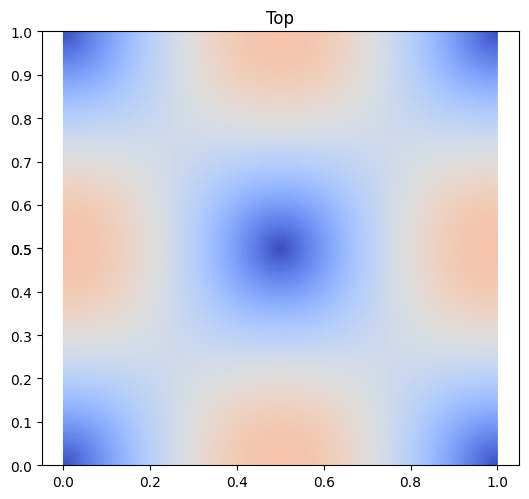

In [29]:
fig, axes = plt.subplots(nrows=2, sharex=True)


tripcolor(z.sub(0), axes=axes[0],vmin=0,vmax=20, cmap='coolwarm')
axes[0].set_aspect("equal")
axes[0].set_title("Top")
axes[0].set_ylim(0.5,1.0)
axes[0].spines['bottom'].set_visible(False)

tripcolor(z.sub(1), axes=axes[1],vmin=0,vmax=20, cmap='coolwarm')
axes[1].set_aspect("equal")
axes[1].set_ylim(0.0,0.5)
axes[1].spines['top'].set_visible(False)

plt.tight_layout(pad=0)
plt.subplots_adjust(hspace=0)

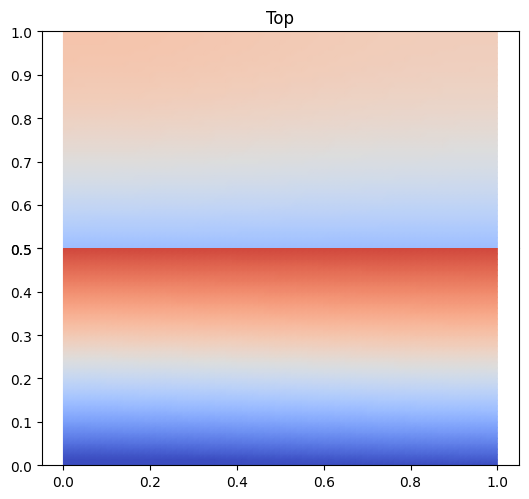

In [30]:
fig, axes = plt.subplots(nrows=2, sharex=True)


tripcolor(z.sub(2), axes=axes[0],vmin=-2000,vmax=2000, cmap='coolwarm')
axes[0].set_aspect("equal")
axes[0].set_title("Top")
axes[0].set_ylim(0.5,1.0)
axes[0].spines['bottom'].set_visible(False)

tripcolor(z.sub(3), axes=axes[1],vmin=-2000,vmax=2000, cmap='coolwarm')
axes[1].set_aspect("equal")
axes[1].set_ylim(0.0,0.5)
axes[1].spines['top'].set_visible(False)

plt.tight_layout(pad=0)
plt.subplots_adjust(hspace=0)

In [31]:
inner(p_top-p_bottom,p_test_bottom) * ds_bottom(5) == inner(Constant(0.), p_test_bottom) * ds_bottom(5)

Equation(Form([Integral(Product(Sum(Indexed(Coefficient(WithGeometry(MixedFunctionSpace(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe658cf0dd0>, VectorElement(FiniteElement('Q', quadrilateral, 2), dim=2), name=None, index=0, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe658cf39e0>, VectorElement(FiniteElement('Q', quadrilateral, 2), dim=2), name=None, index=1, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe658cf0dd0>, FiniteElement('Q', quadrilateral, 1), name=None, index=2, component=None), IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x7fe658cf39e0>, FiniteElement('Q', quadrilateral, 1), name=None, index=3, component=None), name='None_None_None_None'), MeshSequence((Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 8), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 10), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), d

In [32]:
assemble(dot((u_top-u_bottom),as_vector([1,1])) * ds_bottom(5))

np.float64(-5.292687377669911e-17)